In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import sys
sys.path.append('/home/ec2-user/SageMaker/project-delta')
from ttd.datasets import load_dataset_boeckaerts

In [3]:
df = load_dataset_boeckaerts()

In [4]:
df.to_csv("boeckaerts.csv", index=False)

In [57]:
df = pd.read_csv("boeckaerts.csv")
df.head()

,Sequence,Sequence ID
0,LDAVNLTLEALGESRVMDINTSNPSAGLARSALARNRRGLLSTGYW...,A1a
1,MAQSLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRR...,A1a
2,MAMWWAVAALAGSKLLGAGAQIEVSKARNKAVIQQTAKQLNDIALQ...,A1a
3,MPVIQPNRQGLNIGGVQLQANEVNLPSTVGDVAVDTSKANRLAALA...,A1a
4,MAQFLNQEPNPQEKDSAKGATLKPAPESVDWNDAGDAGLNALQRSS...,A1a


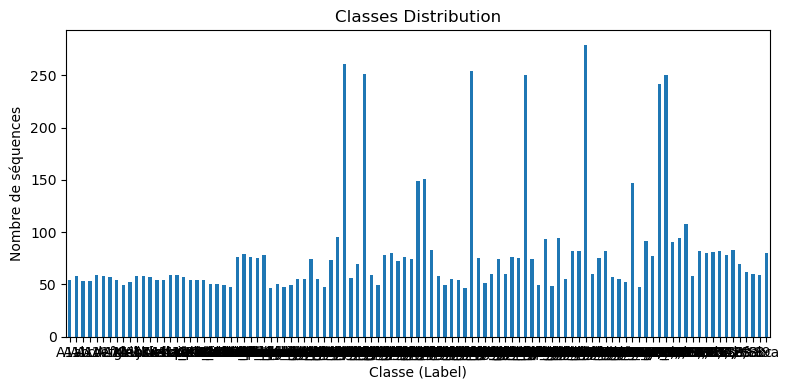

In [58]:
import matplotlib.pyplot as plt

# Tracer l'histogramme de la colonne 'Label'
plt.figure(figsize=(8, 4))
df["Sequence ID"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("Classe (Label)")
plt.ylabel("Nombre de séquences")
plt.title("Classes Distribution")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
from esm.sdk.api import ESMProtein
from esm.models.esmc import ESMC
from ttd.models import BaseModel, ESMEncoder, ProteinDataset

torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Build proteins and labels from DataFrame
proteins = [ESMProtein(sequence=row["Sequence"]) for _, row in df.iterrows()]
dummy_labels = torch.randint(0, 14, (len(df),))
dataset = ProteinDataset(proteins, dummy_labels)
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x[0])

Device: cuda


In [11]:
# CELL IF YOU WANT TO LOAD AN ALREADY EXISTING MODEL
# Rebuild the architecture first
client = ESMC.from_pretrained("esmc_300m").to(device)
encoder = ESMEncoder(client, output="sequence")

hidden_dim = 960
num_classes = 14
basic_classifier = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
).to(device)

base_model = BaseModel(encoder, basic_classifier).to(device)
base_model.load_state_dict(torch.load("base_model_final_14.pt"))
#model_loaded.eval()

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

<All keys matched successfully>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

all_preds = []
all_entropy = []
with torch.no_grad():
    for protein, dummy_label in loader:
        pred_class, probs, entropy = base_model.predict(protein)
        all_preds.append(pred_class.tolist()[0])
        all_entropy.append(entropy.tolist()[0])

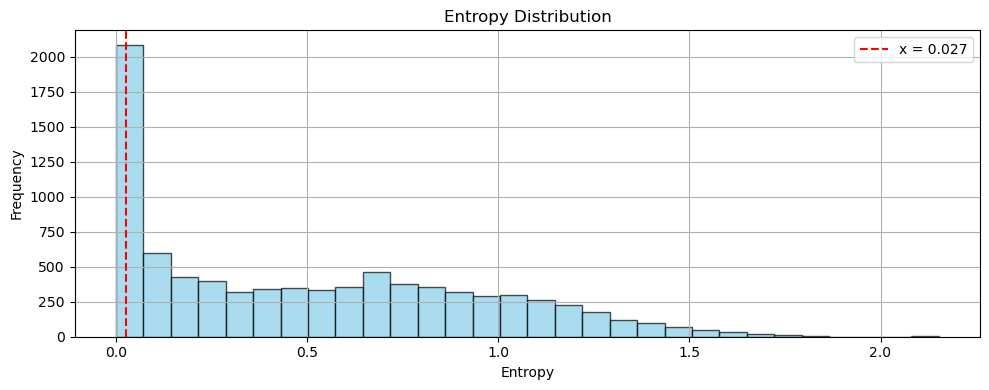

Ratio of entropy < 0.027: 0.1816


In [13]:
import matplotlib.pyplot as plt
import torch

# Define the constant line y = N
N = 0.027  # adjust this to the threshold or reference line you want

# Plot the distribution
plt.figure(figsize=(10, 4))
plt.hist(all_entropy, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=N, color='red', linestyle='--', label=f'x = {N}')
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Entropy Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure all_entropy is a torch tensor
all_entropy_tensor = torch.tensor(all_entropy) if not isinstance(all_entropy, torch.Tensor) else all_entropy

# Calculate ratio
below_N_ratio = (all_entropy_tensor < N).sum().item() / len(all_entropy_tensor)
print(f"Ratio of entropy < {N}: {below_N_ratio:.4f}")

In [14]:
import pickle

# Load
with open("label_to_hr.pkl", "rb") as f:
    label_to_hr = pickle.load(f)

In [59]:
df["pred"] = all_preds
df["entropy"] = all_entropy
df["HR_Pred_Label"] = df["pred"].map(label_to_hr)
df.to_csv("boeckaerts_with_preds.csv", index=False)

In [74]:
df = pd.read_csv("boeckaerts_with_preds.csv")

In [76]:
df.head()

,Sequence,Sequence ID,pred,entropy,HR_Pred_Label
0,LDAVNLTLEALGESRVMDINTSNPSAGLARSALARNRRGLLSTGYW...,A1a,5,0.049194,head-tail adaptor
1,MAQSLEGTIQSLLQGVSQQIPRERQPGQLGAQLNMLSDPVSGLRRR...,A1a,7,0.798806,tail fiber protein
2,MAMWWAVAALAGSKLLGAGAQIEVSKARNKAVIQQTAKQLNDIALQ...,A1a,8,0.912383,tail length tape measure protein
3,MPVIQPNRQGLNIGGVQLQANEVNLPSTVGDVAVDTSKANRLAALA...,A1a,2,0.117883,endolysin
4,MAQFLNQEPNPQEKDSAKGATLKPAPESVDWNDAGDAGLNALQRSS...,A1a,4,1.103103,head maturation protease


/tmp/ipykernel_73536/1087208602.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_of_k_lowest = grouped.apply(


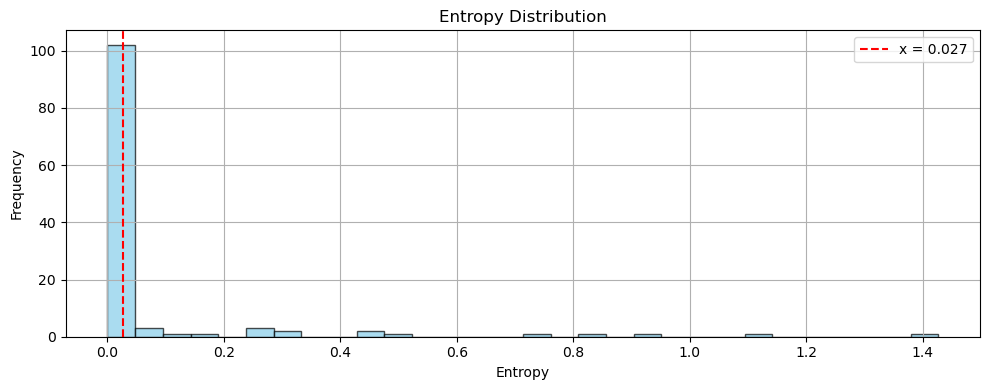

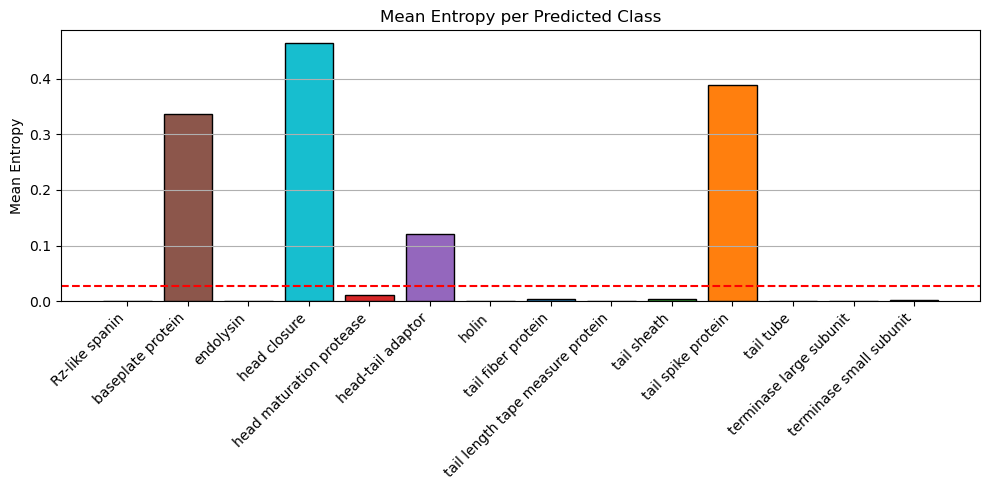

Ratio of entropy < 0.027: 0.8500
['Klebsiella_phage_K17alfa61,' 'Klebsiella_phage_K2PH164C1,'
 'Klebsiella_phage_K45PH128C2,' 'Klebsiella_phage_K54lambda1_1_1,'
 'Klebsiella_phage_K63PH128,' 'Klebsiella_phage_K65PH164,'
 'Klebsiella_phage_K69PH164C2,' 'M5a' 'M5b' 'S8b']


In [78]:
k = 10  # number of lowest entropy rows to average per Sequence_ID
# k = 5
N = 10  # number of top Sequence_IDs to select

# Step 1: Group by Sequence_ID and get k lowest entropy rows for each group
grouped = best_per_class.groupby("Sequence ID")

# Step 2: Compute mean of the k lowest entropy values per Sequence_ID
mean_of_k_lowest = grouped.apply(
    lambda df: df.nsmallest(k, "entropy")["entropy"].mean()
)

# Step 3: Get the top-N Sequence_IDs with the lowest scores
best_sequence_ids = mean_of_k_lowest.nsmallest(N).index

# Step 4: Filter original top_sequences for these Sequence_IDs
top_sequences = best_per_class[best_per_class["Sequence ID"].isin(best_sequence_ids)]

# Define the constant line y = N
N = 0.027  # adjust this to the threshold or reference line you want

# Plot the distribution
plt.figure(figsize=(10, 4))
plt.hist(top_sequences["entropy"], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=N, color='red', linestyle='--', label=f'x = {N}')
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.title("Entropy Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Group by 'pred' and 'HR_Pred_Label', compute mean entropy
entropy_per_class = top_sequences.groupby(['pred', 'HR_Pred_Label'])['entropy'].mean().reset_index()

class_colors = {8: '#1f77b4',
 7: '#1f77b4',
 10: '#ff7f0e',
 9: '#2ca02c',
 12: '#d62728',
 4: '#d62728',
 5: '#9467bd',
 1: '#8c564b',
 2: '#e377c2',
 13: '#e377c2',
 11: '#7f7f7f',
 6: '#bcbd22',
 3: '#17becf',
 0: '#17becf'}

# Create a color list mapped from the 'pred' column using your class_colors dict
bar_colors = entropy_per_class['pred'].map(class_colors)

# Plot with specific colors for each bar
plt.figure(figsize=(10, 5))
plt.bar(
    entropy_per_class['HR_Pred_Label'],
    entropy_per_class['entropy'],
    color=bar_colors,
    edgecolor='black'
)
plt.axhline(y=N, color='red', linestyle='--', label=f'x = {N}')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Entropy")
plt.title("Mean Entropy per Predicted Class")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Ensure all_entropy is a torch tensor
top_sequences_tensor = torch.tensor(top_sequences["entropy"].values) if not isinstance(top_sequences["entropy"], torch.Tensor) else top_sequences["entropy"]

# Calculate ratio
below_N_ratio = (top_sequences_tensor < N).sum().item() / len(top_sequences_tensor)
print(f"Ratio of entropy < {N}: {below_N_ratio:.4f}")

print(top_sequences["Sequence ID"].unique())

top_sequences.to_csv("boeckaerts_top_10_individuals_4.csv", index=False)